In [16]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn import metrics
from sklearn.metrics import confusion_matrix


cudnn.benchmark = True
plt.ion()   # interactive mode

In [17]:
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor()

In [50]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
class_names

['Left_Index',
 'Left_Little',
 'Left_Middle',
 'Left_Ring',
 'Left_Thumb',
 'Right_Index',
 'Right_Little',
 'Right_Middle',
 'Right_Ring',
 'Right_Thumb']

In [42]:
device

device(type='cuda', index=0)

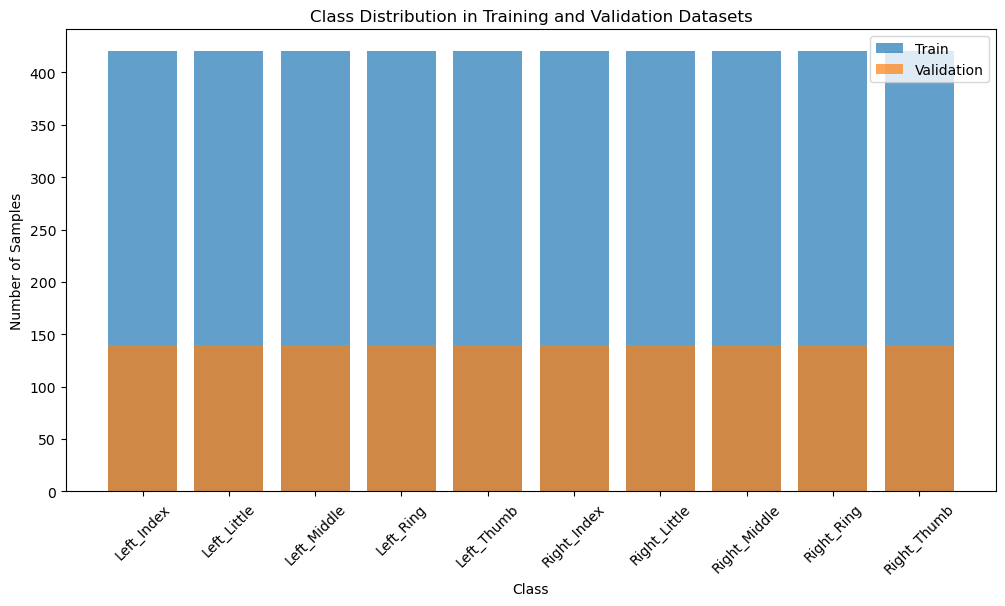

In [51]:
# Count the number of samples in each class for the training dataset
train_class_counts = [0] * len(class_names)
for _, label in image_datasets['train']:
    train_class_counts[label] += 1

# Count the number of samples in each class for the validation dataset
val_class_counts = [0] * len(class_names)
for _, label in image_datasets['val']:
    val_class_counts[label] += 1

# Create a list of class labels for the x-axis
class_labels = [class_names[i] for i in range(len(class_names))]

# Plot the class distribution using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_labels, train_class_counts, label='Train', alpha=0.7)
plt.bar(class_labels, val_class_counts, label='Validation', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training and Validation Datasets')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

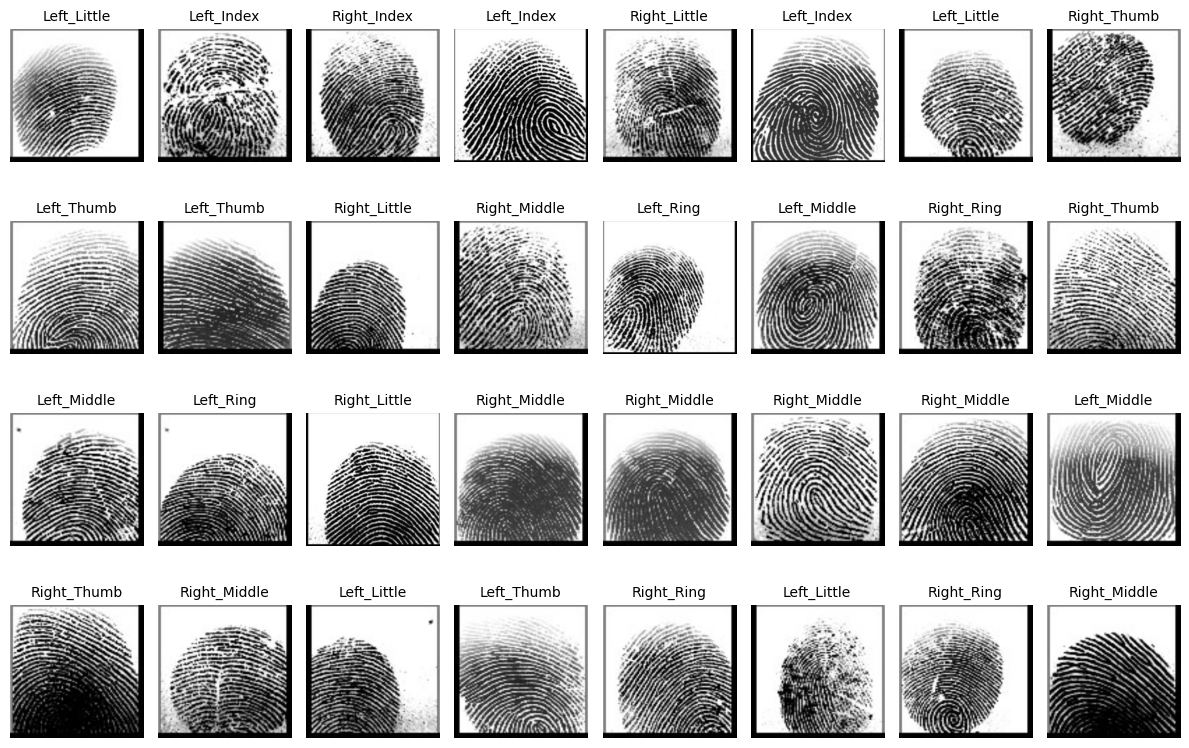

In [54]:
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

# Denormalize the images (if normalization was applied)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images = images * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

# Create a grid of images with labels
image_grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
class_labels = [class_names[label] for label in labels.numpy()]

# Display the image grid with labels using Matplotlib
plt.figure(figsize=(12, 8))

# Display class labels along with each image
for i in range(len(class_labels)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for correct visualization
    plt.title(class_labels[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/anim/.cache/torch/hub/pytorch_vision_v0.10.0
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [58]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.1883 Acc: 0.6236
val Loss: 0.9892 Acc: 0.6771

Epoch 1/29
----------
train Loss: 0.6973 Acc: 0.7474
val Loss: 0.9517 Acc: 0.7079

Epoch 2/29
----------
train Loss: 0.5182 Acc: 0.8176
val Loss: 0.9756 Acc: 0.7221

Epoch 3/29
----------
train Loss: 0.4314 Acc: 0.8505
val Loss: 0.9146 Acc: 0.7393

Epoch 4/29
----------
train Loss: 0.3892 Acc: 0.8619
val Loss: 0.9811 Acc: 0.7314

Epoch 5/29
----------
train Loss: 0.3216 Acc: 0.8869
val Loss: 0.8521 Acc: 0.7521

Epoch 6/29
----------
train Loss: 0.2673 Acc: 0.9090
val Loss: 0.9866 Acc: 0.7357

Epoch 7/29
----------
train Loss: 0.1627 Acc: 0.9452
val Loss: 0.9124 Acc: 0.7521

Epoch 8/29
----------
train Loss: 0.1386 Acc: 0.9564
val Loss: 0.8667 Acc: 0.7514

Epoch 9/29
----------
train Loss: 0.1122 Acc: 0.9679
val Loss: 0.8306 Acc: 0.7607

Epoch 10/29
----------
train Loss: 0.1099 Acc: 0.9719
val Loss: 0.8580 Acc: 0.7636

Epoch 11/29
----------
train Loss: 0.1043 Acc: 0.9733
val Loss: 0.8656 Acc: 0.7571

Ep

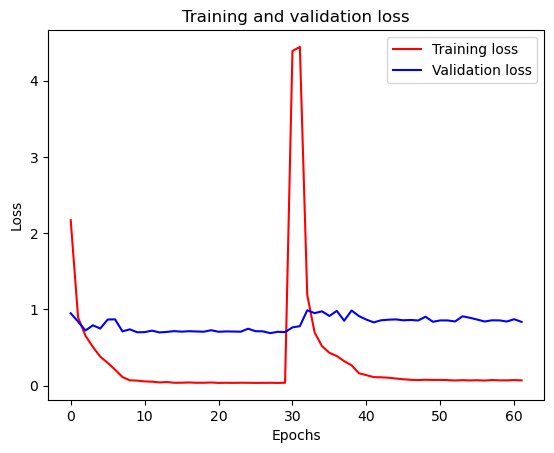

In [59]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
torch.save(model_ft.state_dict(), 'best_model/model01_mobilenetV2.pt')

In [27]:
model_state_dict = torch.load('best_model/model01_mobilenetV2.pt')

# model_state_dict = torch.load('best_model/model03.pt' , map_location=torch.device('cpu'))    ##for cpu only

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft.load_state_dict(model_state_dict)
model_ft.eval()
model_ft.to(device)

Using cache found in /home/anim/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [36]:
# Define a transformation to preprocess the image
pred_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function for making predictions
def predict_class(image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Apply the defined transformation
    image_tensor = pred_transform(Image.fromarray(image))
    image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
    
    # Move the input image to the same device as the model
    image_tensor = image_tensor.to(device)
    
    # Make a prediction
    with torch.no_grad():
        outputs = model_ft(image_tensor)
    
    # Get the predicted class index
    _, predicted_idx = torch.max(outputs, 1)
    
    # Map the class index to the class name (replace 'class_mapping' with your mapping)
    # class_mapping = {0: 'class_0', 1: 'class_1', 2: 'class_2'}  # Replace with your actual class names
    predicted_class = class_names[predicted_idx.item()]
    
    return predicted_class

In [39]:
predict_class("demo/Left_middle.jpg")

'Right_Thumb'